# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Usage

1. Go through the [paper] to understand what the data is about.
1. Download some datasets from <https://github.com/mdeff/fma>.
1. Uncompress the archives, e.g. with `unzip fma_small.zip`.
1. Load and play with the data in this notebook.

[paper]: https://arxiv.org/abs/1612.01840

In [2]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [3]:
# Directory where mp3 are stored.
AUDIO_DIR = '/Users/annelahann/neue-fische/RiffRefine/data/fma_small'
#AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = utils.load('data/tracks.csv')
genres = utils.load('data/genres.csv')
features = utils.load('data/features.csv')
echonest = utils.load('data/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

## 1 Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [4]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


In [5]:
tracks['set'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 106574 entries, 2 to 155320
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   split   106574 non-null  object  
 1   subset  106574 non-null  category
dtypes: category(1), object(1)
memory usage: 1.7+ MB


### 1.1 Subsets

The small and medium subsets can be selected with the below code.

In [6]:
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape
small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 2 to 155066
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   (album, comments)            8000 non-null   int64         
 1   (album, date_created)        8000 non-null   datetime64[ns]
 2   (album, date_released)       5337 non-null   datetime64[ns]
 3   (album, engineer)            1142 non-null   object        
 4   (album, favorites)           8000 non-null   int64         
 5   (album, id)                  8000 non-null   int64         
 6   (album, information)         6502 non-null   category      
 7   (album, listens)             8000 non-null   int64         
 8   (album, producer)            1404 non-null   object        
 9   (album, tags)                8000 non-null   object        
 10  (album, title)               8000 non-null   object        
 11  (album, tracks)              8000 non-null   i

In [7]:
medium = tracks[tracks['set', 'subset'] <= 'medium'] #Small subset is included within medium
medium.shape

(25000, 52)

## 2 Genres

The genre hierarchy is stored in `genres.csv` and distributed in `fma_metadata.zip`.

In [8]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163 entries, 1 to 1235
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   #tracks    163 non-null    int64 
 1   parent     163 non-null    int64 
 2   title      163 non-null    object
 3   top_level  163 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [9]:
genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


In [10]:
genres['parent'].unique() # this identifies which top level genre the title belongs to

array([  38,    0,   20,   14,    6, 1235,   12,   17,    4,   15,   65,
          2,   45,    9,   25,   10,   92,   21,   53,   31,   26,   13,
         86,    5,  297,  109,   19,  182,  181,   85,  468,  651,   46,
        130,   18,    3,   79,   16,  102,  763])

In [11]:
genres['title'].unique() #title is subgenre 

array(['Avant-Garde', 'International', 'Blues', 'Jazz', 'Classical',
       'Novelty', 'Comedy', 'Old-Time / Historic', 'Country', 'Pop',
       'Disco', 'Rock', 'Easy Listening', 'Soul-RnB', 'Electronic',
       'Sound Effects', 'Folk', 'Soundtrack', 'Funk', 'Spoken', 'Hip-Hop',
       'Audio Collage', 'Punk', 'Post-Rock', 'Lo-Fi', 'Field Recordings',
       'Metal', 'Noise', 'Psych-Folk', 'Krautrock', 'Jazz: Vocal',
       'Experimental', 'Electroacoustic', 'Ambient Electronic',
       'Radio Art', 'Loud-Rock', 'Latin America', 'Drone', 'Free-Folk',
       'Noise-Rock', 'Psych-Rock', 'Bluegrass', 'Electro-Punk', 'Radio',
       'Indie-Rock', 'Industrial', 'No Wave', 'Free-Jazz',
       'Experimental Pop', 'French', 'Reggae - Dub', 'Afrobeat',
       'Nerdcore', 'Garage', 'Indian', 'New Wave', 'Post-Punk', 'Sludge',
       'African', 'Freak-Folk', 'Jazz: Out', 'Progressive',
       'Alternative Hip-Hop', 'Death-Metal', 'Middle East',
       'Singer-Songwriter', 'Ambient', 'Hardcore', 

In [12]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


In [13]:
genres.sort_values('#tracks').head(10)

,#tracks,parent,title,top_level
genre_id,,,,
175,0,86,Bollywood,2
178,0,4,Be-Bop,4
377,1,19,Deep Funk,14
173,4,86,N. Indian Traditional,2
493,4,651,Western Swing,9
374,9,20,Banter,20
808,12,46,Salsa,2
174,17,86,South Indian Traditional,2
465,18,20,Musical Theater,20


## 3 Features

1. Features extracted from the audio for all tracks.
2. For some tracks, data colected from the [Echonest](http://the.echonest.com/) API.

In [14]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


### 3.1 Echonest features

In [15]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

249 features for 13129 tracks


,album_date,album_name,artist_latitude,artist_location,artist_longitude,artist_name,release
track_id,,,,,,,
2,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
3,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
5,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
10,2008-03-11,Constant Hitmaker,39.9523,"Philadelphia, PA, US",-75.1624,Kurt Vile,Constant Hitmaker
134,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
track_id,,,,,
2,0.388990,0.386740,0.406370,0.000000,0.000000
3,0.388990,0.386740,0.406370,0.000000,0.000000
5,0.388990,0.386740,0.406370,0.000000,0.000000
10,0.557339,0.614272,0.798387,0.005158,0.354516
134,0.388990,0.386740,0.406370,0.000000,0.000000


,artist_discovery_rank,artist_familiarity_rank,artist_hotttnesss_rank,song_currency_rank,song_hotttnesss_rank
track_id,,,,,
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
10,2635.0,2544.0,397.0,115691.0,67609.0
134,NaN,NaN,NaN,NaN,NaN


,000,001,002,003,004,005,006,007,008,009,...,214,215,216,217,218,219,220,221,222,223
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
3,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
5,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
10,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
134,0.610849,0.569169,0.428494,0.345796,0.376920,0.460590,0.401371,0.449900,0.428946,0.446736,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


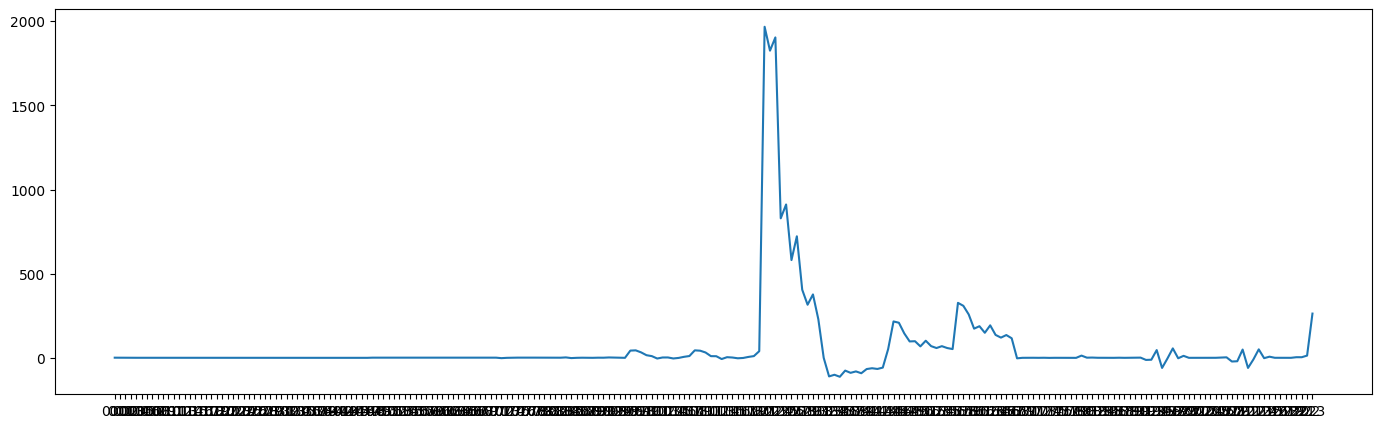

In [16]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x);

### 3.2 Features like MFCCs are discriminant

((2000, 2), (2000,))

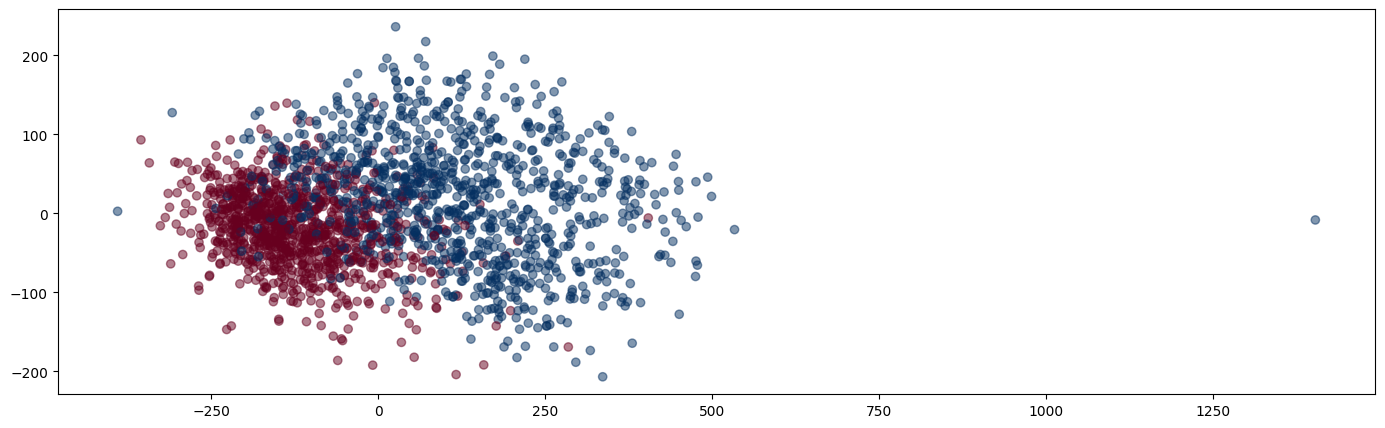

In [17]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

## 4 Audio

You can load the waveform and listen to audio in the notebook itself.

In [35]:
filename = utils.get_audio_path(AUDIO_DIR, 5)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))
start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: /Users/annelahann/neue-fische/RiffRefine/data/fma_small/000/000005.mp3
Duration: 30.00s, 1323119 samples


And use [librosa](https://github.com/librosa/librosa) to compute spectrograms and audio features.

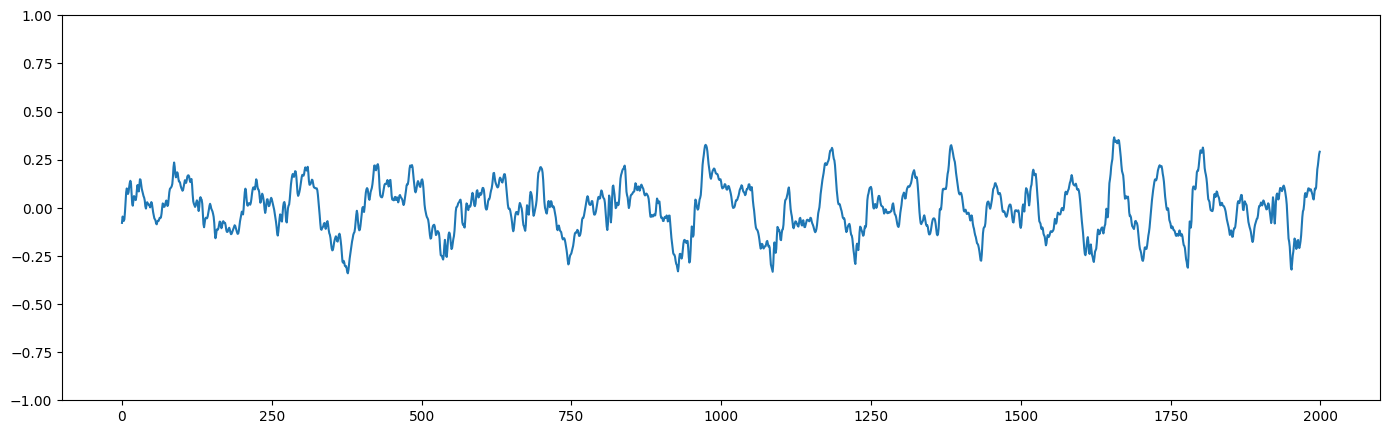

In [36]:
#librosa.display.waveshow(sr);
#plt.vlines([start, end], -1, 1)

x, sr = librosa.load(filename, sr=None, mono=True)
start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));

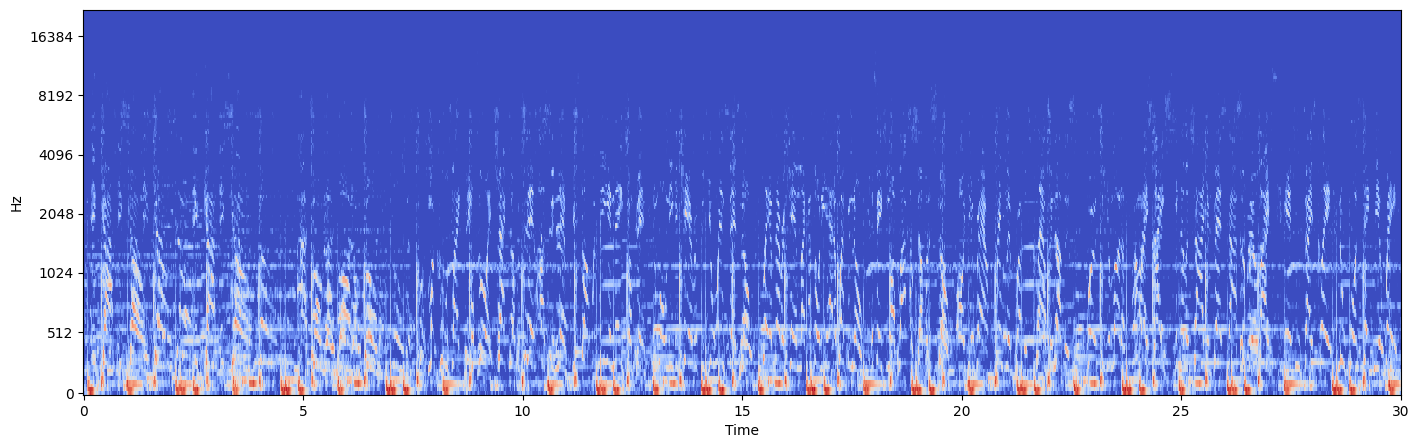

In [37]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

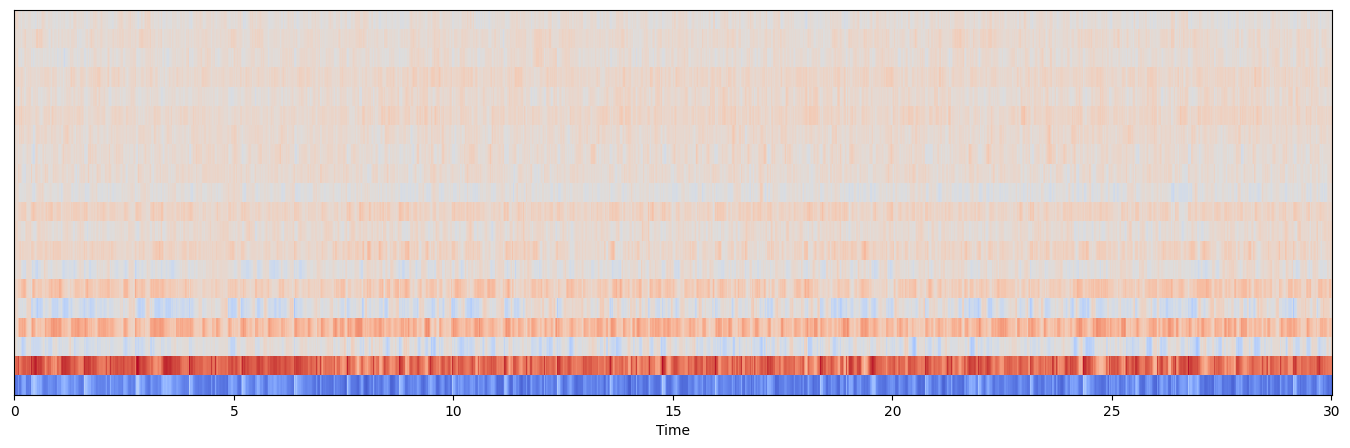

In [38]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

## 5 Genre classification

### 5.1 From features

In [22]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [23]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 46.38%


In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_test_predicted=clf.predict(X_test)

print(confusion_matrix(y_test, y_test_predicted))
print(classification_report(y_test, y_test_predicted))

[[60  9  0 11  4  3  7  6]
 [11 44  6  1 19  5  8  6]
 [ 3 35 20  0  6 17 11  8]
 [13  5  3 68  3  2  3  3]
 [ 5 23 23  0 42  1  6  0]
 [13  1 21 11  1 48  4  1]
 [29  3  8 13  1 12 25  9]
 [ 3  9  4  4  6  1  9 64]]
               precision    recall  f1-score   support

   Electronic       0.44      0.60      0.51       100
 Experimental       0.34      0.44      0.38       100
         Folk       0.24      0.20      0.22       100
      Hip-Hop       0.63      0.68      0.65       100
 Instrumental       0.51      0.42      0.46       100
International       0.54      0.48      0.51       100
          Pop       0.34      0.25      0.29       100
         Rock       0.66      0.64      0.65       100

     accuracy                           0.46       800
    macro avg       0.46      0.46      0.46       800
 weighted avg       0.46      0.46      0.46       800



In [25]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y = tracks.loc[small, ('track', 'listens')]
y_df=pd.DataFrame(y)
y_df['listens_bins'] = pd.qcut(y_df['track','listens'], q=10,labels=range(1, 11))

y_train = y_df.loc[small & train, ('listens_bins')]
y_test = y_df.loc[small & test, ('listens_bins')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))
y_train.value_counts()

6400 training examples, 800 testing examples
140 features, 10 classes


listens_bins
6     659
8     657
1     651
3     646
9     645
2     639
7     634
4     630
10    624
5     615
Name: count, dtype: int64

In [26]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))


Accuracy: 13.38%


In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_test_predicted=clf.predict(X_test)

print(confusion_matrix(y_test, y_test_predicted))
print(classification_report(y_test, y_test_predicted))

[[13 12  9  4  1  3  4  4  9  3]
 [11 19  8  7  3  9  3  3  9  6]
 [ 7  8 10 11  1  5  5  9  8 10]
 [ 9 13 12 11  5 10  6  9 10  7]
 [ 9 13  7 16  5 14 10  5  5 10]
 [ 6  8  8  5  0 16  4  9 10 11]
 [ 6 11  8  9  2 11  5  1 11 11]
 [ 6  5  5  6  4  6  2  5 13 12]
 [16  6  5  4  3 13  3 11 10 10]
 [21  5  7  6  5 11  6 12 17 13]]
              precision    recall  f1-score   support

           1       0.12      0.21      0.16        62
           2       0.19      0.24      0.21        78
           3       0.13      0.14      0.13        74
           4       0.14      0.12      0.13        92
           5       0.17      0.05      0.08        94
           6       0.16      0.21      0.18        77
           7       0.10      0.07      0.08        75
           8       0.07      0.08      0.08        64
           9       0.10      0.12      0.11        81
          10       0.14      0.13      0.13       103

    accuracy                           0.13       800
   macro avg       

### 5.2 From audio